# Giới Thiệu Transformer
Sự nổi tiếng của mô hình Transformer thì không cần phải bàn cãi, vì nó chính là nền tảng của rất nhiều mô hình khác mà nổi tiếng nhất là BERT (Bidirectional Encoder Representations from Transformers) một mô hình dùng để học biểu diễn của các từ tốt nhất hiện tại và đã tạo ra một bước ngoặc lớn cho động đồng NLP trong năm 2019. Và chính Google cũng đã áp dụng BERT trong cỗ máy tìm kiếm của họ. Để hiểu BERT, các bạn cần phải nắm rõ về mô hình Transformer.

![alt text](https://pbcquoc.github.io/images/transformer/bert.jpg)

Ý tưởng chủ đạo của Transformer vẫn là áp dụng cơ thể Attention, những ở mức phức tạp hơn và thật sự là thú vị hơn so với cách được đề xuất trước đó trong một bài báo của tác giả Lương Minh Thắng, một người Việt rất nổi tiếng trong cộng đồng deep learning.

## Tổng Quan Mô Hình
Để cho dễ cảm nhận được cách mà mô hình hoạt động, mình sẽ trình bày trước toàn bộ kiến trúc mô hình ở mức high-level và sau đó sẽ đi chi tiết từng phần nhỏ cũng như công thức toán của nó.

Giống như những mô hình dịch máy khác, kiến trúc tổng quan của mô hình transformer bao gồm 2 phần lớn là encoder và decoder. Encoder dùng để học vector biểu của câu với mong muốn rằng vector này mang thông tin hoàn hảo của câu đó. Decoder thực hiện chức năng chuyển vector biểu diễn kia thành ngôn ngữ đích.

Trong ví dụ ở dưới, encoder của mô hình transformer nhận một câu tiếng việt, và encode thành một vector biểu diễn ngữ nghĩa của câu little sun, sau đó mô hình decoder nhận vector biểu diễn này, và dịch nó thành câu tiếng việt mặt trời bé nhỏ

![alt text](https://pbcquoc.github.io/images/transformer/overview.jpg)

Một trong những ưu điểm của transformer là mô hình này có khả năng xử lý song song cho các từ. Như các bạn thấy, Encoders của mô hình transfomer là một dạng feedforward neural nets, bao gồm nhiều encoder layer khác, mỗi encoder layer này xử lý đồng thời các từ. Trong khi đó, với mô hình LSTM, thì các từ phải được xử lý tuần tự. Ngoài ra, mô hình Transformer còn xử lý câu đầu vào theo 2 hướng mà không cần phải stack thêm một môt hình LSTM nữa như trong kiến trúc Bidirectional LSTM.

![alt text](https://pbcquoc.github.io/images/transformer/overview2.jpg)

Một cái nhìn vừa tổng quát và chi tiết sẽ giúp ích cho các bạn. Mình sẽ đi vào chi tiết một số phần cực kì quan trọng như sinusoidal position encoding, multi head attention của encoder, còn của decoder thì các bạn thấy được kiến trúc rất giống với của encoder, do đó mình sẽ chỉ đi nhanh qua mà thôi.

![](https://pbcquoc.github.io/images/transformer/overview3.jpg)

In [2]:
! pip -q install torchtext==0.6.0
! pip -q install pyvi
! pip -q install https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz
! python -m spacy link vi_spacy_model vi_spacy_model

import nltk
nltk.download('wordnet')

  ERROR: HTTP error 404 while getting https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz
ERROR: Could not install requirement https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz because of HTTP error 404 Client Error: Not Found for url: https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz for URL https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz
⚠ As of spaCy v3.0, model symlinks are not supported anymore. You can
load trained pipeline packages using their full names or from a directory
path.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
import math
from torchtext import datasets

# Embedding Layer with Position Encoding
Trước khi đi vào mô hình encoder, chúng ta sẽ tìm hiểu cơ chế rất thú vị là Position Encoding dùng để đưa thông tin về vị trí của các từ vào mô hình transformer.

Đầu tiên, các từ được biểu diễn bằng một vector sử dụng một ma trận word embedding có số dòng bằng kích thước của tập từ vựng. Sau đó các từ trong câu được tìm kiếm trong ma trận này, và được nối nhau thành các dòng của một ma trận 2 chiều chứa ngữ nghĩa của từng từ riêng biệt. Nhưng như các bạn đã thấy, transformer xử lý các từ song song, do đó, với chỉ word embedding mô hình không thể nào biết được vị trí các từ. Như vậy, chúng ta cần một cơ chế nào đó để đưa thông tin vị trí các từ vào trong vector đầu vào. Đó là lúc positional encoding xuất hiện và giải quyết vấn đề của chúng ta. Tuy nhiên, trước khi giới thiệu cơ chế position encoding của tác giả, các bạn có thể giải quyết vấn đề băng một số cách naive như sau:

Biểu diễn vị trí các từ bằng chuỗi các số liên tục từ 0,1,2,3 …, n. Tuy nhiên, chúng ta gặp ngay vấn đề là khi chuỗi dài thì số này có thể khá lớn, và mô hình sẽ gặp khó khăn khi dự đoán những câu có chiều dài lớn hơn tất cả các câu có trong tập huấn luyện. Để giải quyết vấn đề này, các bạn có thể chuẩn hóa lại cho chuỗi số này nằm trong đoạn từ 0-1 bằng cách chia cho n nhưng mà chúng ta sẽ gặp vấn đề khác là khoảng cách giữ 2 từ liên tiếp sẽ phụ thuộc vào chiều dài của chuỗi, và trong một khoản cố định, chúng ta không hình dùng được khoản đó chứa bao nhiêu từ. Điều này có nghĩa là ý nghĩa của position encoding sẽ khác nhau tùy thuộc vào độ dài của câu đó.

In [4]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model

        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embed(x)

# Embedder(100, 512)(torch.LongTensor([1,2,3,4])).shape

# Phương pháp đề xuất sinusoidal position encoding
Phương pháp của tác giả đề xuất không gặp những hạn chế mà chúng ta vừa nêu. Vị trí của các từ được mã hóa bằng một vector có kích thước bằng word embedding và được cộng trực tiếp vào word embedding.

![](https://pbcquoc.github.io/images/transformer/embedding.jpg)

Cụ thể, tại vị trí chẵn, tác giả sử dụng hàm sin, và với vị trí lẽ tác giả sử dụng hàm cos để tính giá trị tại chiều đó.

![alt text](https://github.com/pbcquoc/pbcquoc.github.io/raw/master/images/transformer/pe_formula.png)

Trong hình dưới này, mình minh họa cho cách tính position encoding của tác giả. Giả sử chúng ta có word embedding có 6 chiều, thì position encoding cũng có tương ứng là 6 chiều. Mỗi dòng tương ứng với một từ. Giá trị của các vector tại mỗi vị trí được tính toán theo công thức ở hình dưới.

![](https://pbcquoc.github.io/images/transformer/pe.png)

Lúc này một số bạn sẽ thắc mắc tại sao với cách biểu diện vị trí như tác giả đề xuất lại có thể mã hóa thông tin vị trí của từ? Hãy tưởng tượng bạn có các số từ 0-15. Các bạn có thể thấy rằng bit ngoài cùng bên phải thay đổi nhanh nhất mỗi 1 số, và sau đó là bit bên phải thứ 2, thay đổi mỗi 2 số, tương tự cho các bit khác.

![](https://pbcquoc.github.io/images/transformer/pe_intuition.jpg)

Trong công thức của tác giả đề xuất, các bạn cũng thấy rằng, hàm sin và cos có dạng đồ thị tần số và tần số này giảm dần ở các chiều lớn dần. Các bạn xem hình dưới, ở chiều 0, giá trị thay đổi liên tục tương ứng với màu sắc thay đổi liên tục, và tần số thay đổi này giảm dần ở các chiều lớn hơn.

![](https://pbcquoc.github.io/images/transformer/pe_heatmap.png)

Nên chúng ta có thể cảm nhận được việc biểu diễn của tác giả khá tương tự như cách biểu diễn các số nguyên trong hệ nhị phân, cho nên chúng ta có thể biểu diễn được vị trí các từ theo cách như vậy.

Chúng ta cũng có thể xem ma trận khoảng cách của các vector biểu diễn vị trí như hình dưới. Rõ ràng, các vector biểu diễn thể hiện được tính chất khoảng cách giữ 2 từ. 2 từ cách càng xa nhau thì khoảng cách càng lớn hơn.

![](https://pbcquoc.github.io/images/transformer/pe_distance.png)

Ngoài ra, một tính chất của phương pháp tác giả đề xuất là nó cho phép mô hình dễ dàng học được mối quan hệ tương đối giữ các từ. Cụ thể, biểu diễn vị trí của từ t + offset có thể chuyển thành biểu diễn vị trí của từ t bằng một phép biến đổi tuyến tính dựa trên ma trận phép quay.

Để dễ hình dung phương pháp của tác giả đề xuất lại hoạt động tốt, các bạn có thể tưởng tượng, hàm sin, và cos, giống như là kim giây và kim phút trên đồng hồ. Với 2 kim này, chúng ta có thể biểu diễn được 3600 vị trí. Và đồng thời có thể hiểu được ngay tại sao biểu diễn của từ t + offset và từ t lại có thể dễ dàng chuyển đổi cho nhau.



In [5]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_length=200, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_length, d_model)

        # Bảng pe mình vẽ ở trên
        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x*math.sqrt(self.d_model)
        seq_length = x.size(1)

        pe = Variable(self.pe[:, :seq_length], requires_grad=False)

        if x.is_cuda:
            pe.cuda()
        # cộng embedding vector với pe
        x = x + pe
        x = self.dropout(x)

        return x

# PositionalEncoder(512)(torch.rand(5, 30, 512)).shape

# Encoder
Encoder của mô hình transformer có thể bao gồm nhiều encoder layer tượng tự nhau. Mỗi encoder layer của transformer lại bao gồm 2 thành phần chính là multi head attention và feedforward network, ngoài ra còn có cả skip connection và normalization layer.

Trong 2 thành phần chính này, các bạn sẽ hứng thú nhiều hơn về multi-head attention vì đó là một layer mới được giới thiệu trong bài báo này, và chính nó tạo nên sự khác biệt giữ mô hình LSTM và mô hình Transformer mà chúng ta đang tìm hiểu.
![alt text](https://pbcquoc.github.io/images/transformer/encoder.jpg)

Encoder đầu tiên sẽ nhận ma trận biểu diễn của các từ đã được cộng với thông tin vị trí thông qua positional encoding. Sau đó, ma trận này sẽ được xử lý bởi Multi Head Attention. Multi Head Attention thật chất là self-attention, nhưng mà để mô hình có thể có chú ý nhiều pattern khác nhau, tác giả đơn giản là sử dụng nhiều self-attention.

## Self Attention Layer
Self Attention cho phép mô hình khi mã hóa một từ có thể sử dụng thông tin của những từ liên quan tới nó. Ví dụ khi từ nó được mã hóa, nó sẽ chú ý vào các từ liên quan như là mặt trời. Cơ chế self attention này có ý nghĩa tương tự như cơ chế attention mình đã chia sẻ ở bài trước và những công thức toán học cũng tương ứng với nhau.

![alt text](https://pbcquoc.github.io/images/transformer/self_attention.jpg)

Bạn có thể tưởng tượng cơ chế self attention giống như cơ chế tìm kiếm. Với một từ cho trước, cơ chế này sẽ cho phép mô hình tìm kiếm trong cách từ còn lại, từ nào “giống” để sau đó thông tin sẽ được mã hóa dựa trên tất cả các từ trên.

Đầu tiên, với môi từ chúng ta cần tạo ra 3 vector: query, key, value vector bằng cách nhân ma trận biểu diễn các từ đầu vào với ma trận học tương ứng.

* query vector: vector dùng để chứa thông tin của từ được tìm kiếm, so sách. Giống như là câu query của google search.
* key vector: vector dùng để biểu diễn thông tin các từ được so sánh với từ cần tìm kiếm ở trên. Ví dụ, như các trang webs mà google sẽ so sánh với từ khóa mà bạn tìm kiếm.
* value vector: vector biểu diễn nội dung, ý nghĩa của các từ. Các bạn có thể tượng tượng, nó như là nội dung trang web được hiển thị cho người dùng sau khi tìm kiếm.
Để tính tương quan, chúng ta đơn giản chỉ cần tính tích vô hướng dựa các vector query và key. Sau đó dùng hàm softmax để chuẩn hóa chỉ số tương quan trong đoạn 0-1, và cuối cùng, tính trung bình cộng có trọng số giữa các vector values sử dụng chỉ số tương quan mới tính được. Quá dễ !!!

![](https://pbcquoc.github.io/images/transformer/self_attention_2.png)

Cụ thể hơn, quá trình tính toán attention vector có thể được tóm tắt làm 3 bước như sau:

* Bước 1: Tính ma trận query, key, value bằng cách khởi tạo 3 ma trận trọng số query, key, vector. Sau đó nhân input với các ma trận trọng số này để tạo thành 3 ma trận tương ứng.
* Bước 2: Tính attention weights. Nhân 2 ma trận key, query vừa được tính ở trên với nhau để với ý nghĩa là so sánh giữ câu query và key để học mối tương quan. Sau đó thì chuẩn hóa về đoạn [0-1] bằng hàm softmax. 1 có nghĩa là câu query giống với key, 0 có nghĩa là không giống.
* Bước 3: Tính output. Nhân attention weights với ma trận value. Điều này có nghĩa là chúng ta biểu diễn một từ bằng trung bình có trọng số (attention weights) của ma trận value.

![](https://pbcquoc.github.io/images/transformer/attention_vector.jpg)

## Multi Head Attention
Chúng ta muốn mô hình có thể học nhiều kiểu mối quan hệ giữ các từ với nhau. Với mỗi self-attention, chúng ta học được một kiểu pattern, do đó để có thể mở rộng khả năng này, chúng ta đơn giản là thêm nhiều self-attention. Tức là chúng ta cần nhiều ma trận query, key, value mà thôi. Giờ đây ma trận trọng số key, query, value sẽ có thêm 1 chiều depth nữa.

![](https://pbcquoc.github.io/images/transformer/multi_head_attention.jpg)

Multi head attention cho phép mô hình chú ý đến đồng thời những pattern dễ quan sát được như sau.

* Chú ý đến từ kế trước của một từ
* Chú ý đến từ kế sau của một từ
* Chú ý đến những từ liên quan của một từ

In [6]:
def attention(q, k, v, mask=None, dropout=None):
    """
    q: batch_size x head x seq_length x d_model
    k: batch_size x head x seq_length x d_model
    v: batch_size x head x seq_length x d_model
    mask: batch_size x 1 x 1 x seq_length
    output: batch_size x head x seq_length x d_model
    """

    # attention score được tính bằng cách nhân q với k
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask==0, -1e9)
    # xong rồi thì chuẩn hóa bằng softmax
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output, scores

# attention(torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512)).shape

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0

        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.attn = None

        # tạo ra 3 ma trận trọng số là q_linear, k_linear, v_linear như hình trên
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        q: batch_size x seq_length x d_model
        k: batch_size x seq_length x d_model
        v: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        bs = q.size(0)
        # nhân ma trận trọng số q_linear, k_linear, v_linear với dữ liệu đầu vào q, k, v
        # ở bước encode các bạn lưu ý rằng q, k, v chỉ là một (xem hình trên)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # tính attention score
        scores, self.attn = attention(q, k, v, mask, self.dropout)

        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)
        return output

# MultiHeadAttention(8, 512)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 30, 512)).shape

# Residuals Connection và Normalization Layer

Trong kiến trúc của mô hình transformer, residuals connection và mormalization layer được sử dụng mọi nơi, giống như tinh thần của nó. 2 kỹ thuật giúp cho mô hình huấn luyện nhanh hội tụ hơn và trách mất mát thông tin trong quá trình huấn luyện mô hình, ví dụ như là thông tin của vị trí các từ được mã hóa.



In [8]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [9]:
class FeedForward(nn.Module):
    """ Trong kiến trúc của chúng ta có tầng linear
    """
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        x: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """


        x2 = self.norm_1(x)
        # tính attention value, các bạn để ý q, k, v là giống nhau
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# EncoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32 , 1, 30)).shape

# Decoder
Decoder thực hiện chức năng giải mã vector của câu nguồn thành câu đích, do đó decoder sẽ nhận thông tin từ encoder là 2 vector key và value. Kiến trúc của decoder rất giống với encoder, ngoại trừ có thêm một multi head attention nằm ở giữ dùng để học mối liên quan giữ từ đang được dịch với các từ được ở câu nguồn.

![alt text](https://pbcquoc.github.io/images/transformer/decoder.jpg)

## Masked Multi Head Attention
Masked Multi Head Attention tất nhiên là multi head attention mà chúng ta đã nói đến ở trên, có chức năng dùng đề encode các từ câu câu đích trong quá trình dịch, tuy nhiên, lúc cài đặt chúng ta cần lưu ý rằng phải che đi các từ ở tương lai chưa được mô hình dịch đến, để làm việc này thì đơn giản là chúng ta chỉ cần nhân với một vector chứa các giá trị 0,1.

Trong decoder còn có một multi head attention khác có chức năng chú ý các từ ở mô hình encoder, layer này nhận vector key và value từ mô hình encoder, và output từ layer phía dưới. Đơn giản bởi vì chúng ta muốn so sánh sự tương quan giữ từ đang được dịch vời các từ nguồn.

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: batch_size x seq_length x d_model
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        """
        # Các bạn xem hình trên, kiến trúc mình vẽ với code ở chỗ này tương đương nhau.
        x2 = self.norm_1(x)
        # multihead attention thứ nhất, chú ý các từ ở target
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        # masked mulithead attention thứ 2. k, v là giá trị output của mô hình encoder
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

# DecoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

# Cài đặt Encoder
bao gồm N encoder layer

In [12]:
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    """Một encoder có nhiều encoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask):
        """
        src: batch_size x seq_length
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

# Encoder(232, 512,6,8,0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 1, 30)).shape

# Cài đặt Decoder
bao gồm N decoder layers

In [13]:
class Decoder(nn.Module):
    """Một decoder có nhiều decoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        trg: batch_size x seq_length
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

# Decoder(232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

# Cài đặt Transformer
bao gồm encoder và decoder

In [14]:
class Transformer(nn.Module):
    """ Cuối cùng ghép chúng lại với nhau để được mô hình transformer hoàn chỉnh
    """
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: batch_size x seq_length
        trg: batch_size x seq_length
        src_mask: batch_size x 1 x seq_length
        trg_mask batch_size x 1 x seq_length
        output: batch_size x seq_length x vocab_size
        """
        e_outputs = self.encoder(src, src_mask)

        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

# Transformer(232, 232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.LongTensor(32, 30).random_(0, 10),torch.rand(32, 1, 30),torch.rand(32, 1, 30)).shape

Chúng ta sử dụng torchtext để load dữ liệu, giúp giảm thời gian và hiệu quả

In [15]:
from torchtext import data

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)

        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [17]:
def nopeak_mask(size, device):
    """Tạo mask được sử dụng trong decoder để lúc dự đoán trong quá trình huấn luyện
     mô hình không nhìn thấy được các từ ở tương lai
    """
    np_mask = np.triu(np.ones((1, size, size)),
    k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    np_mask = np_mask.to(device)

    return np_mask

def create_masks(src, trg, src_pad, trg_pad, device):
    """ Tạo mask cho encoder,
    để mô hình không bỏ qua thông tin của các kí tự PAD do chúng ta thêm vào
    """
    src_mask = (src != src_pad).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != trg_pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask

    else:
        trg_mask = None
    return src_mask, trg_mask

In [18]:
from nltk.corpus import wordnet
import re

def get_synonym(word, SRC):
    syns = wordnet.synsets(word)
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]

    return 0

def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

In [19]:
def init_vars(src, model, SRC, TRG, device, k, max_len):
    """ Tính toán các ma trận cần thiết trong quá trình translation sau khi mô hình học xong
    """
    init_tok = TRG.vocab.stoi['<sos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)

    # tính sẵn output của encoder
    e_output = model.encoder(src, src_mask)

    outputs = torch.LongTensor([[init_tok]])

    outputs = outputs.to(device)

    trg_mask = nopeak_mask(1, device)
    # dự đoán kí tự đầu tiên
    out = model.out(model.decoder(outputs,
    e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)

    probs, ix = out[:, -1].data.topk(k)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0)

    outputs = torch.zeros(k, max_len).long()
    outputs = outputs.to(device)
    outputs[:, 0] = init_tok
    outputs[:, 1] = ix[0]

    e_outputs = torch.zeros(k, e_output.size(-2),e_output.size(-1))

    e_outputs = e_outputs.to(device)
    e_outputs[:, :] = e_output[0]

    return outputs, e_outputs, log_scores

def k_best_outputs(outputs, out, log_scores, i, k):

    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)

    row = k_ix // k
    col = k_ix % k

    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)

    return outputs, log_scores

def beam_search(src, model, SRC, TRG, device, k, max_len):

    outputs, e_outputs, log_scores = init_vars(src, model, SRC, TRG, device, k, max_len)
    eos_tok = TRG.vocab.stoi['<eos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)
    ind = None
    for i in range(2, max_len):

        trg_mask = nopeak_mask(i, device)

        out = model.out(model.decoder(outputs[:,:i],
        e_outputs, src_mask, trg_mask))

        out = F.softmax(out, dim=-1)

        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, k)

        ones = (outputs==eos_tok).nonzero() # Occurrences of end symbols for all input sentences.
        sentence_lengths = torch.zeros(len(outputs), dtype=torch.long).cuda()
        for vec in ones:
            i = vec[0]
            if sentence_lengths[i]==0: # First end symbol has not been found yet
                sentence_lengths[i] = vec[1] # Position of first end symbol

        num_finished_sentences = len([s for s in sentence_lengths if s > 0])

        if num_finished_sentences == k:
            alpha = 0.7
            div = 1/(sentence_lengths.type_as(log_scores)**alpha)
            _, ind = torch.max(log_scores * div, 1)
            ind = ind.data[0]
            break

    if ind is None:

        length = (outputs[0]==eos_tok).nonzero()[0] if len((outputs[0]==eos_tok).nonzero()) > 0 else -1
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[0][1:length]])

    else:
        length = (outputs[ind]==eos_tok).nonzero()[0]
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[ind][1:length]])

In [20]:
def translate_sentence(sentence, model, SRC, TRG, device, k, max_len):
    """Dịch một câu sử dụng beamsearch
    """
    model.eval()
    indexed = []
    sentence = SRC.preprocess(sentence)

    for tok in sentence:
        if SRC.vocab.stoi[tok] != SRC.vocab.stoi['<eos>']:
            indexed.append(SRC.vocab.stoi[tok])
        else:
            indexed.append(get_synonym(tok, SRC))

    sentence = Variable(torch.LongTensor([indexed]))

    sentence = sentence.to(device)

    sentence = beam_search(sentence, model, SRC, TRG, device, k, max_len)

    return  multiple_replace({' ?' : '?',' !':'!',' .':'.','\' ':'\'',' ,':','}, sentence)

In [21]:
import spacy
import re

class tokenize(object):

    def __init__(self, lang):
        self.nlp = spacy.load(lang)

    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text != " "]

## Data loader
Sử dụng torchtext để load dữ liệu nhanh chóng

In [22]:
import os
import dill as pickle
import pandas as pd

def read_data(src_file, trg_file):
    src_data = open(src_file).read().strip().split('\n')

    trg_data = open(trg_file).read().strip().split('\n')

    return src_data, trg_data

def create_fields(src_lang, trg_lang):

    print("loading spacy tokenizers...")

    t_src = tokenize(src_lang)
    t_trg = tokenize(trg_lang)

    TRG = data.Field(lower=True, tokenize=t_trg.tokenizer, init_token='<sos>', eos_token='<eos>')
    SRC = data.Field(lower=True, tokenize=t_src.tokenizer)

    return SRC, TRG

def create_dataset(src_data, trg_data, max_strlen, batchsize, device, SRC, TRG, istrain=True):

    print("creating dataset and iterator... ")

    raw_data = {'src' : [line for line in src_data], 'trg': [line for line in trg_data]}
    df = pd.DataFrame(raw_data, columns=["src", "trg"])

    mask = (df['src'].str.count(' ') < max_strlen) & (df['trg'].str.count(' ') < max_strlen)
    df = df.loc[mask]

    df.to_csv("translate_transformer_temp.csv", index=False)

    data_fields = [('src', SRC), ('trg', TRG)]
    train = data.TabularDataset('./translate_transformer_temp.csv', format='csv', fields=data_fields)

    train_iter = MyIterator(train, batch_size=batchsize, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=istrain, shuffle=True)

    os.remove('translate_transformer_temp.csv')

    if istrain:
        SRC.build_vocab(train)
        TRG.build_vocab(train)

    return train_iter


In [23]:
def step(model, optimizer,batch, criterion):
    """
    Một lần cập nhật mô hình
    """
    model.train()

    src = batch.src.transpose(0,1).cuda()
    trg = batch.trg.transpose(0,1).cuda()
    trg_input = trg[:, :-1]
    src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
    preds = model(src, trg_input, src_mask, trg_mask)

    ys = trg[:, 1:].contiguous().view(-1)

    optimizer.zero_grad()
    loss = criterion(preds.view(-1, preds.size(-1)), ys)
    loss.backward()
    optimizer.step_and_update_lr()

    loss = loss.item()

    return loss

In [24]:
def validiate(model, valid_iter, criterion):
    """ Tính loss trên tập validation
    """
    model.eval()

    with torch.no_grad():
        total_loss = []
        for batch in valid_iter:
            src = batch.src.transpose(0,1).cuda()
            trg = batch.trg.transpose(0,1).cuda()
            trg_input = trg[:, :-1]
            src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
            preds = model(src, trg_input, src_mask, trg_mask)

            ys = trg[:, 1:].contiguous().view(-1)

            loss = criterion(preds.view(-1, preds.size(-1)), ys)

            loss = loss.item()

            total_loss.append(loss)

    avg_loss = np.mean(total_loss)

    return avg_loss

# Optimizer
Để huấn luyện mô hình transformer, các bạn vẫn sử dụng Adam, tuy nhiên, learning rate cần phải được điều chỉnh trong suốt quá trình học theo công thức sau

![alt text](https://raw.githubusercontent.com/pbcquoc/pbcquoc.github.io/master/images/transformer/optimizer.png)

![alt text](https://pbcquoc.github.io/images/transformer/opt.png)


In [25]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr':self.init_lr,
            'd_model':self.d_model,
            'n_warmup_steps':self.n_warmup_steps,
            'n_steps':self.n_steps,
            '_optimizer':self._optimizer.state_dict(),
        }

        return optimizer_state_dict

    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']

        self._optimizer.load_state_dict(state_dict['_optimizer'])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

# Label Smoothing
Với mô hình nhiều triệu tham số của transformer, thì việt overfit là chuyện dễ dàng xảy ra. Để hạn chế hiện tượng overfit, các bạn có thể sử dụng kỹ thuật label smoothing. Về cơ bản thì ý tưởng của kỹ thuật này khá đơn giản, chúng ta sẽ phạt mô hình khi nó quá tự tin vào việc dự đoán của mình. Thay vì mã hóa nhãn là một one-hot vector, các bạn sẽ thay đổi nhãn này một chút bằng cách phân bố một tí xác suất vào các trường hợp còn lại.

![alt text](https://pbcquoc.github.io/images/transformer/label_smoothing.jpg)

Giờ thì các bạn sẽ an tâm khi có thể để số epoch lớn mà không lo rằng mô hình sẽ overfit nặng nề.



In [26]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [27]:
from torchtext.data.metrics import bleu_score

def bleu(valid_src_data, valid_trg_data, model, SRC, TRG, device, k, max_strlen):
    pred_sents = []
    for sentence in valid_src_data:
        pred_trg = translate_sentence(sentence, model, SRC, TRG, device, k, max_strlen)
        pred_sents.append(pred_trg)

    pred_sents = [TRG.preprocess(sent) for sent in pred_sents]
    trg_sents = [[sent.split()] for sent in valid_trg_data]

    return bleu_score(pred_sents, trg_sents)

In [36]:
opt = {
    'train_src_data':'/content/data/train.en',
    'train_trg_data':'/content/data/train.vi',
    'valid_src_data':'/content/data/tst2013.en',
    'valid_trg_data':'/content/data/tst2013.vi',
    'src_lang':'en_core_web_sm',
    'trg_lang':'en_core_web_sm',#'vi_spacy_model',
    'max_strlen':160,
    'batchsize':1500,
    'device':'cuda',
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':10,
    'printevery': 200,
    'k':5,
}

In [37]:
os.makedirs('./data/', exist_ok=True)
! gdown --id 1Fuo_ALIFKlUvOPbK5rUA5OfAS2wKn_95

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Fuo_ALIFKlUvOPbK5rUA5OfAS2wKn_95
To: /content/en_vi.zip
100% 10.1M/10.1M [00:00<00:00, 133MB/s]


In [38]:
! unzip -o en_vi.zip

Archive:  en_vi.zip
  inflating: data/tst2013.en         
  inflating: data/tst2012.vi         
  inflating: data/train.en           
  inflating: data/tst2013.vi         
  inflating: data/train.vi           
  inflating: data/tst2012.en         


In [39]:
train_src_data, train_trg_data = read_data(opt['train_src_data'], opt['train_trg_data'])
valid_src_data, valid_trg_data = read_data(opt['valid_src_data'], opt['valid_trg_data'])

SRC, TRG = create_fields(opt['src_lang'], opt['trg_lang'])
train_iter = create_dataset(train_src_data, train_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=True)
valid_iter = create_dataset(valid_src_data, valid_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=False)

loading spacy tokenizers...
creating dataset and iterator... 
creating dataset and iterator... 


In [40]:
src_pad = SRC.vocab.stoi['<pad>']
trg_pad = TRG.vocab.stoi['<pad>']

In [41]:
model = Transformer(len(SRC.vocab), len(TRG.vocab), opt['d_model'], opt['n_layers'], opt['heads'], opt['dropout'])

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(opt['device'])

In [42]:
optimizer = ScheduledOptim(
        torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),
        0.2, opt['d_model'], 4000)

criterion = LabelSmoothingLoss(len(TRG.vocab), padding_idx=trg_pad, smoothing=0.1)

In [43]:
import time

for epoch in range(opt['epochs']):
    total_loss = 0

    for i, batch in enumerate(train_iter):
        s = time.time()
        loss = step(model, optimizer, batch, criterion)

        total_loss += loss

        if (i + 1) % opt['printevery'] == 0:
            avg_loss = total_loss/opt['printevery']
            print('epoch: {:03d} - iter: {:05d} - train loss: {:.4f} - time: {:.4f}'.format(epoch, i, avg_loss, time.time()- s))
            total_loss = 0

    s = time.time()
    valid_loss = validiate(model, valid_iter, criterion)
    bleuscore = bleu(valid_src_data[:500], valid_trg_data[:500], model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
    print('epoch: {:03d} - iter: {:05d} - valid loss: {:.4f} - bleu score: {:.4f} - time: {:.4f}'.format(epoch, i, valid_loss, bleuscore, time.time() - s))


epoch: 000 - iter: 00199 - train loss: 9.2933 - time: 0.1909
epoch: 000 - iter: 00399 - train loss: 8.3999 - time: 0.1734
epoch: 000 - iter: 00599 - train loss: 7.1698 - time: 0.2008
epoch: 000 - iter: 00799 - train loss: 6.6288 - time: 0.1858
epoch: 000 - iter: 00999 - train loss: 6.4694 - time: 0.1970
epoch: 000 - iter: 01199 - train loss: 6.3351 - time: 0.1951
epoch: 000 - iter: 01399 - train loss: 6.0989 - time: 0.1746
epoch: 000 - iter: 01599 - train loss: 5.9274 - time: 0.1826
epoch: 000 - iter: 01799 - train loss: 5.6540 - time: 0.2056
epoch: 000 - iter: 01999 - train loss: 5.5457 - time: 0.1956
epoch: 000 - iter: 02199 - train loss: 5.4914 - time: 0.1692
epoch: 000 - iter: 02399 - train loss: 5.3953 - time: 0.1883
epoch: 000 - iter: 02497 - valid loss: 3.9695 - bleu score: 0.0120 - time: 170.5303
epoch: 001 - iter: 00199 - train loss: 5.1833 - time: 0.1599
epoch: 001 - iter: 00399 - train loss: 5.1425 - time: 0.1803
epoch: 001 - iter: 00599 - train loss: 4.9941 - time: 0.1956
e

In [ ]:
torch.save(model.state_dict(), './transformer.pth')

In [44]:
bleu(valid_src_data, valid_trg_data, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])

0.2461990863084793

In [45]:
sentence='My family was not poor , and myself , I had never experienced hunger .'
trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
trans_sent

'gia đình tôi không nghèo, và bản thân tôi, tôi chưa bao giờ trải qua nạn đói.'

# Visualize

Nếu các bạn không muốn train tốn thời gian thì có thể sử dụng uncomment để download model mình đã train nhé.

In [ ]:
# ! gdown --id 1Ty1bGrd0sCwEqXhsoViCUaNKa3lFwmPH
# model.load_state_dict(torch.load('./transformer.pth'))

In [46]:
import seaborn
import matplotlib.pyplot as plt

def draw(data, x, y, ax):
    seaborn.heatmap(data,
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,
                    cbar=False, ax=ax, annot=False)

# Visualize Encoder
Dùng heatmap để visualize giá trị attention sẽ cho chúng ta biết khi encode một câu mô hình chú ý từ gì ở lân cận

Encoder Layer 2


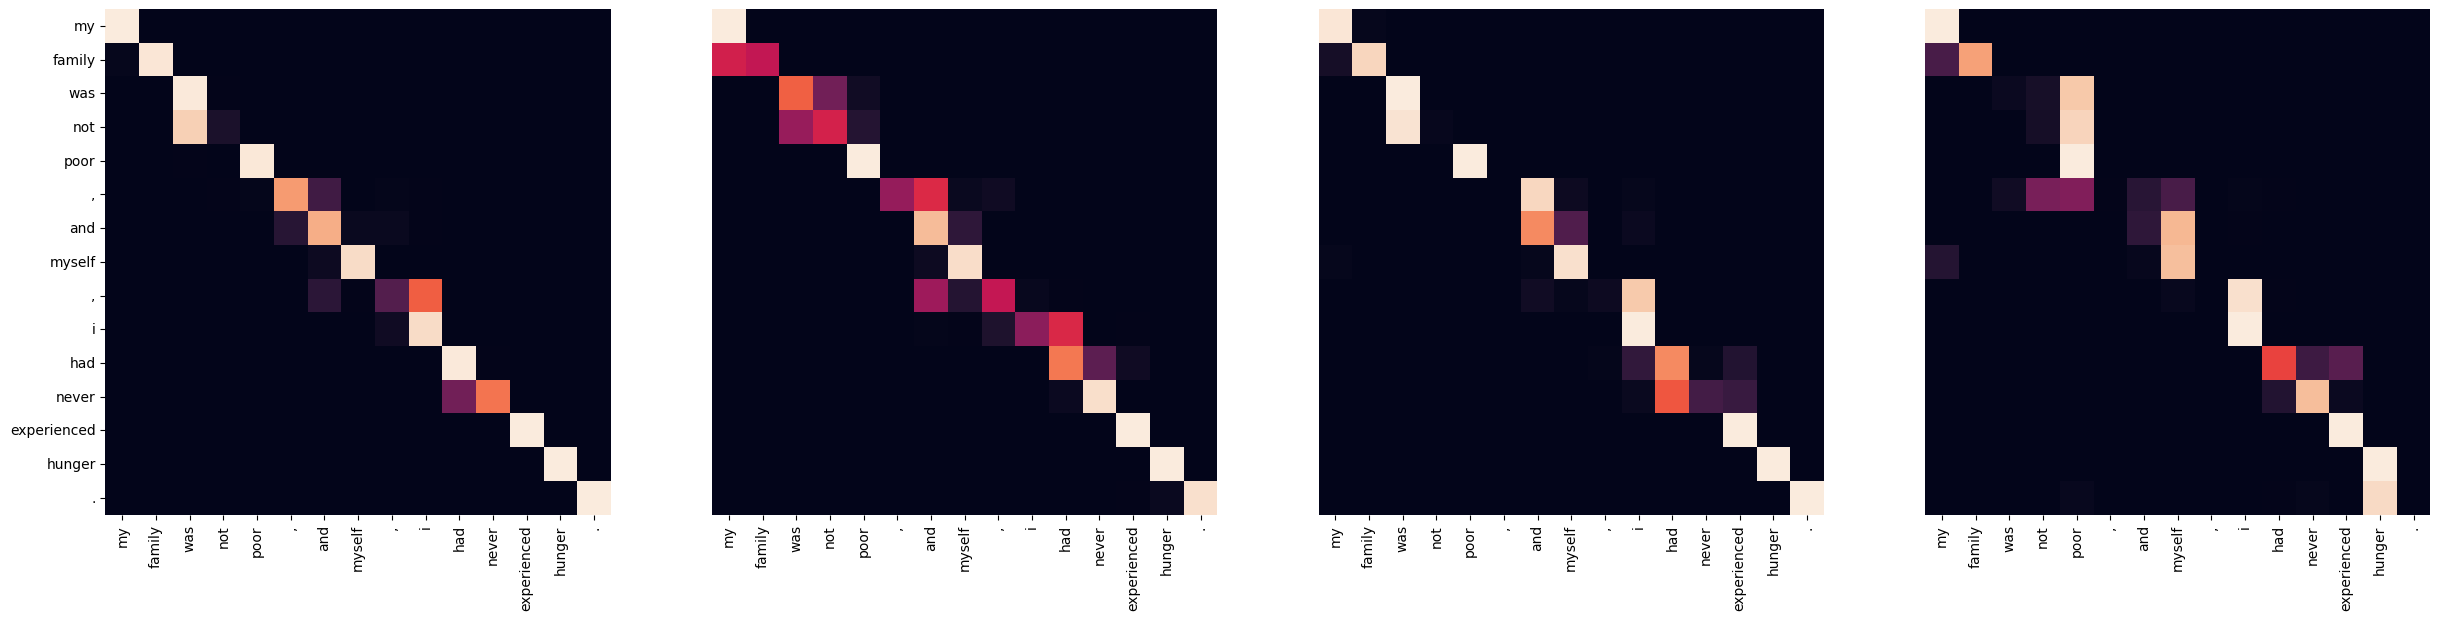

Encoder Layer 4


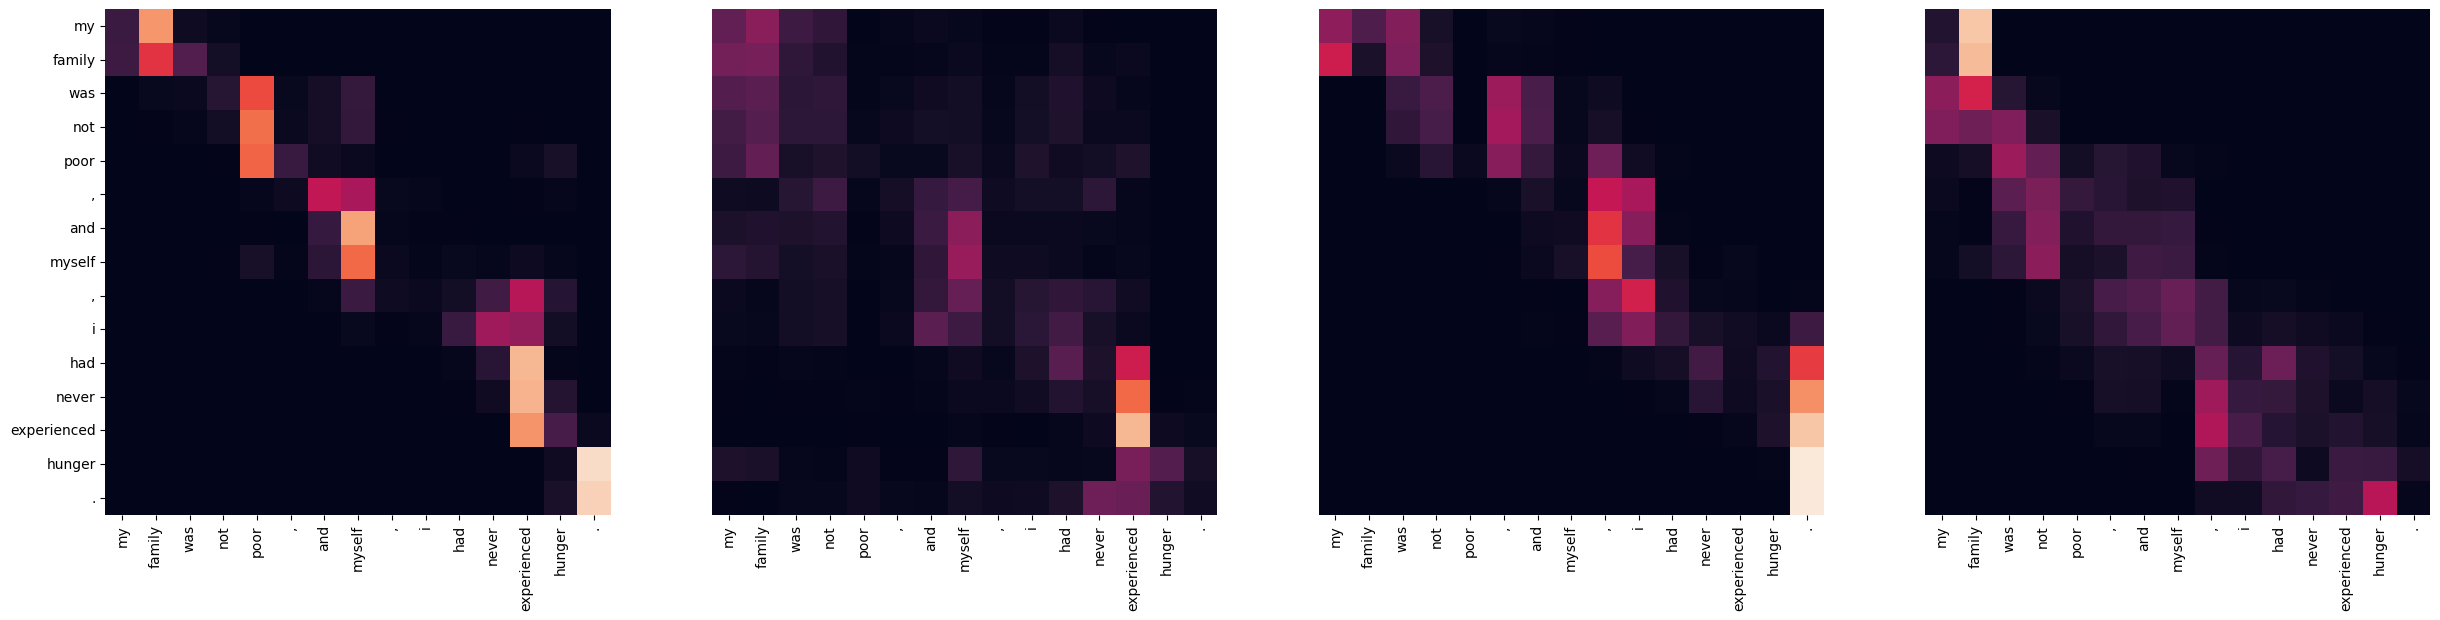

Encoder Layer 6


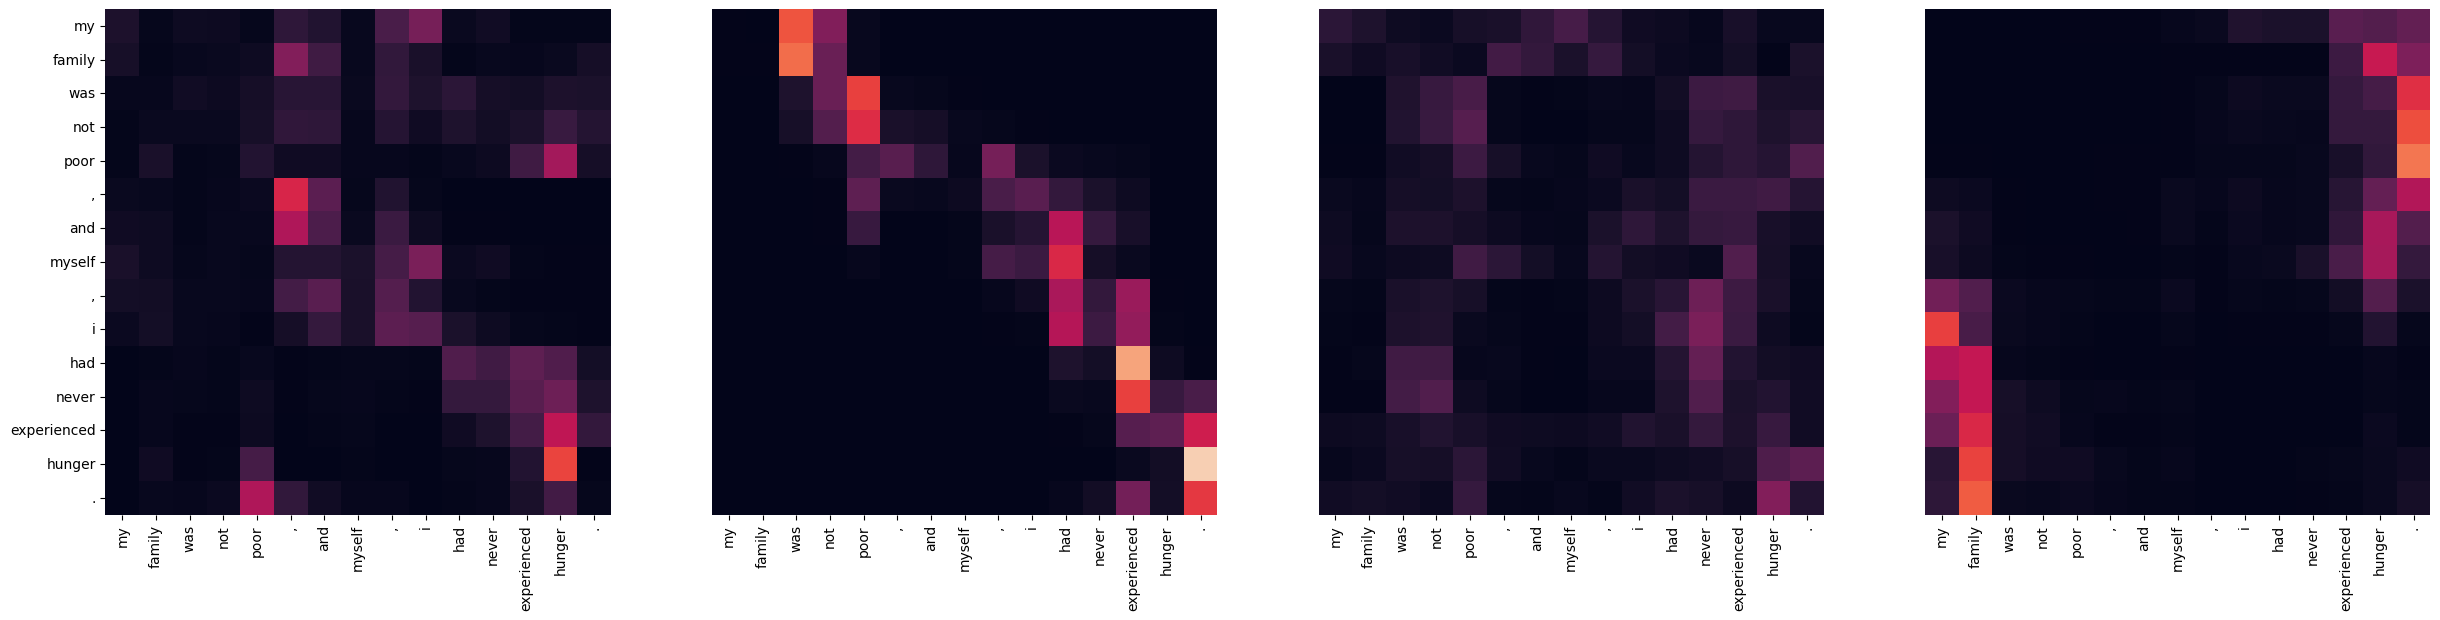

In [47]:
sent = SRC.preprocess(sentence)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(30, 15))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].attn.attn[0, h].data.cpu(),
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

# Visualize Decoder
Ở decoder, các bạn có 2 loại visualization
* self attention: giá trị attention khi mô hình decoder mã hóa câu đích lúc dịch
* src attention: giá trị attention khi mô hình decoder sử dụng câu src

Decoder Self Layer 2


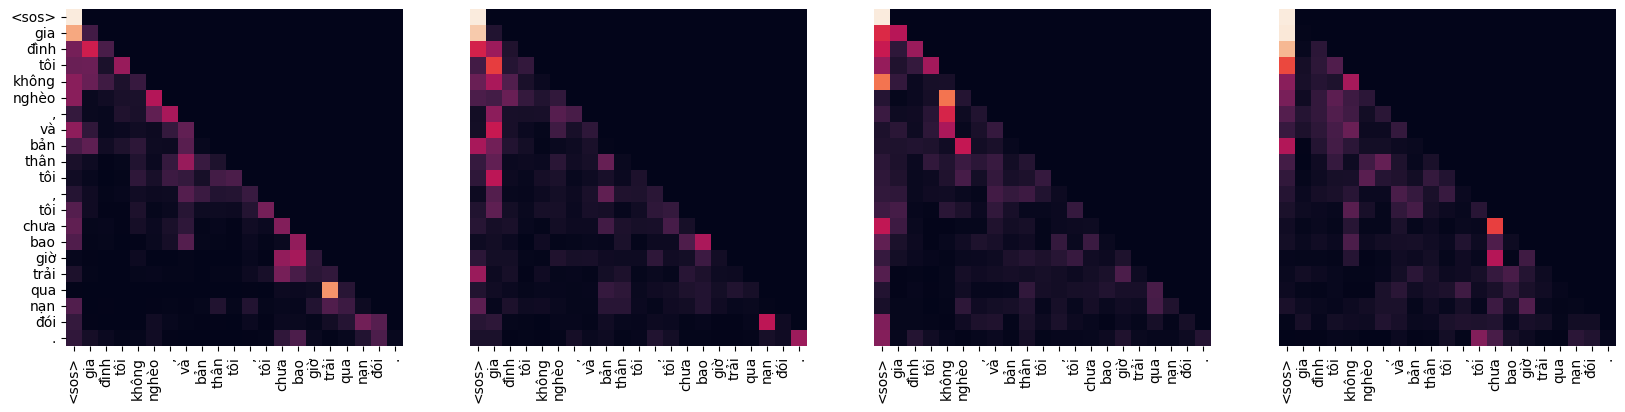

Decoder Src Layer 2


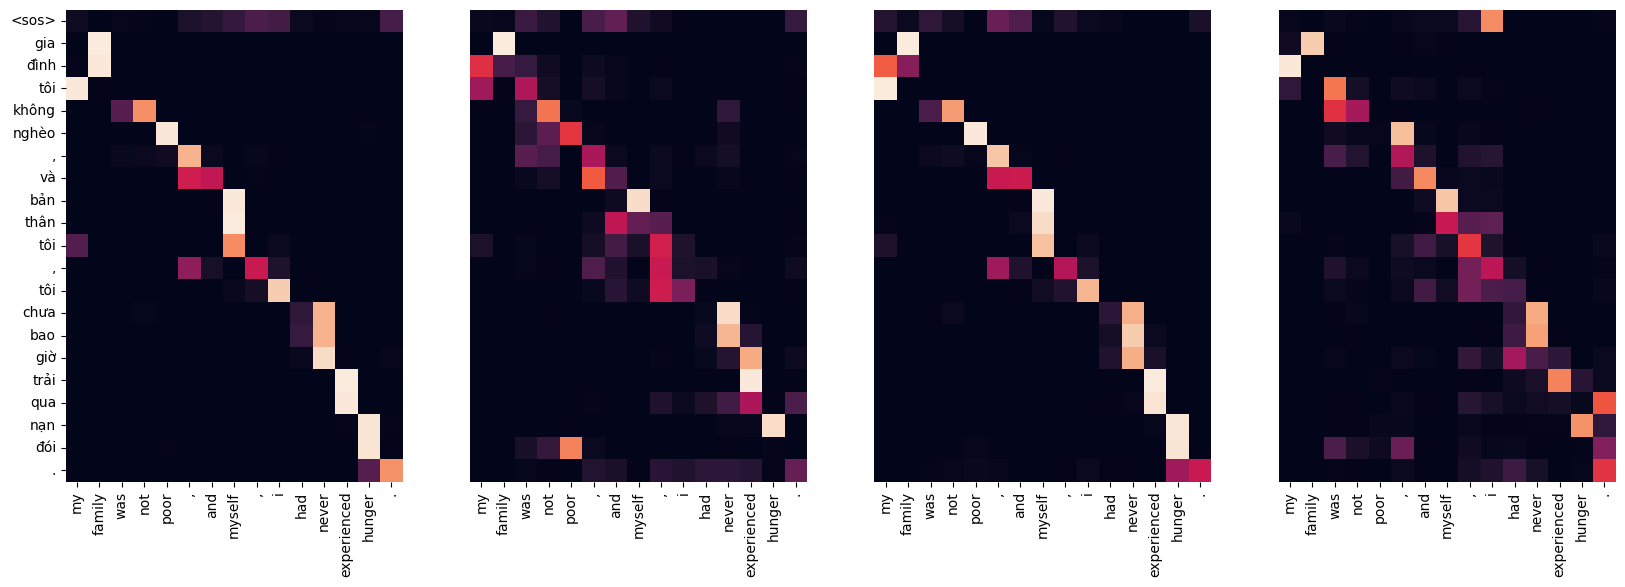

Decoder Self Layer 4


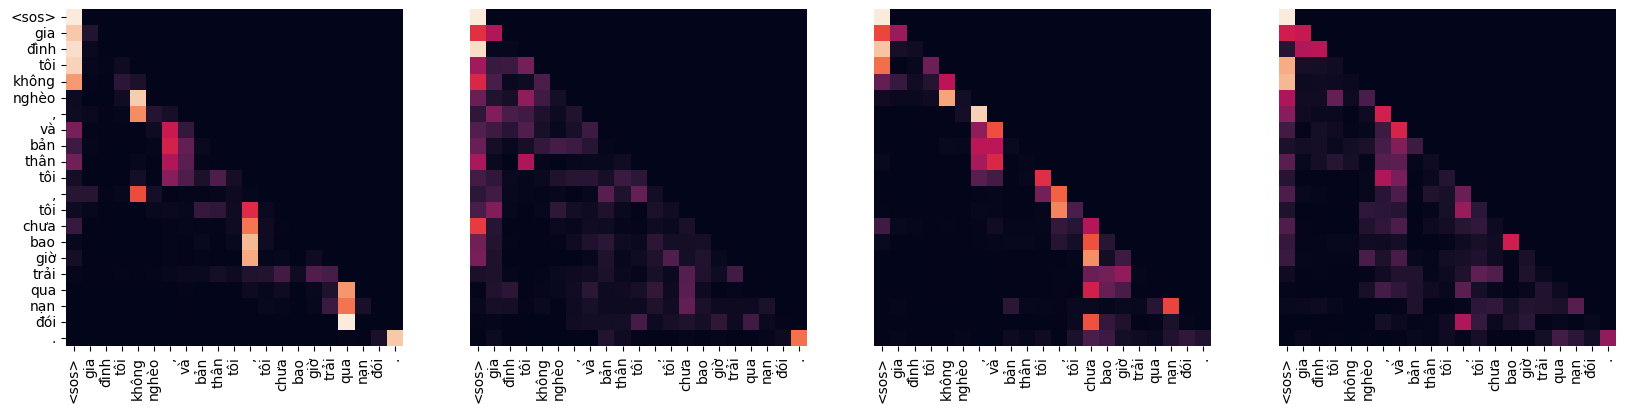

Decoder Src Layer 4


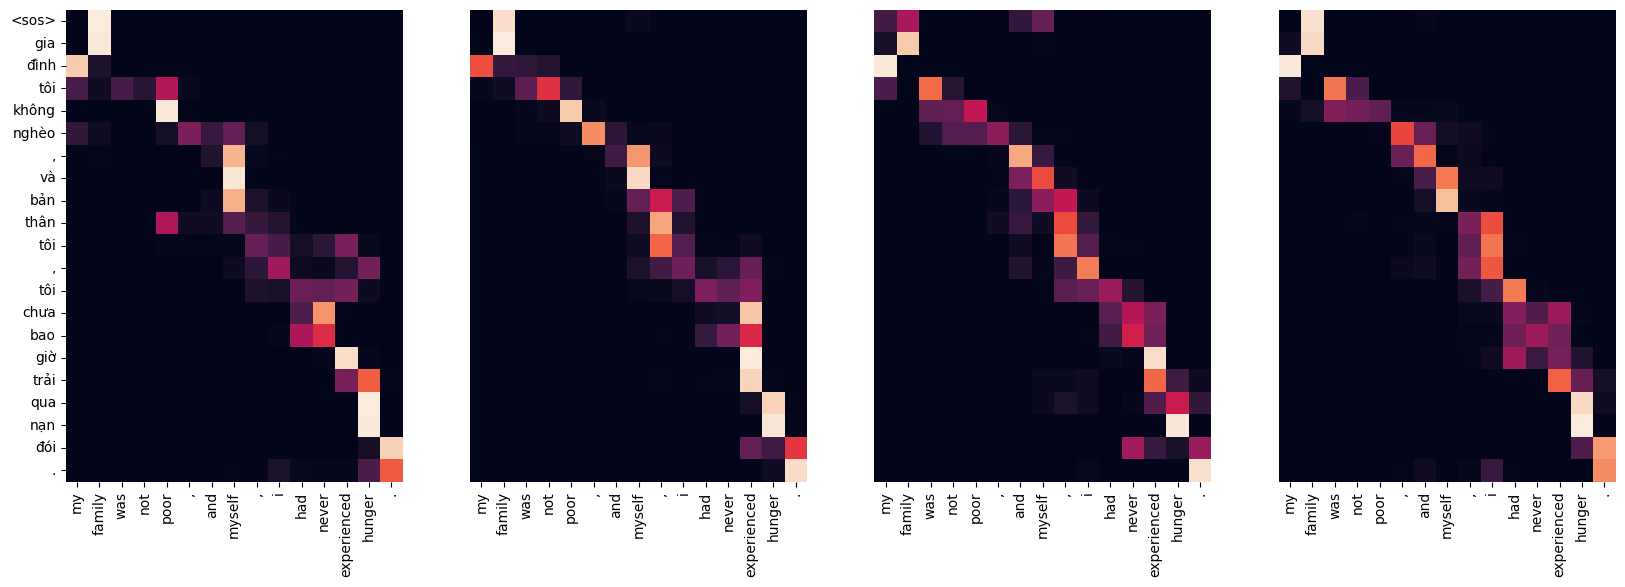

Decoder Self Layer 6


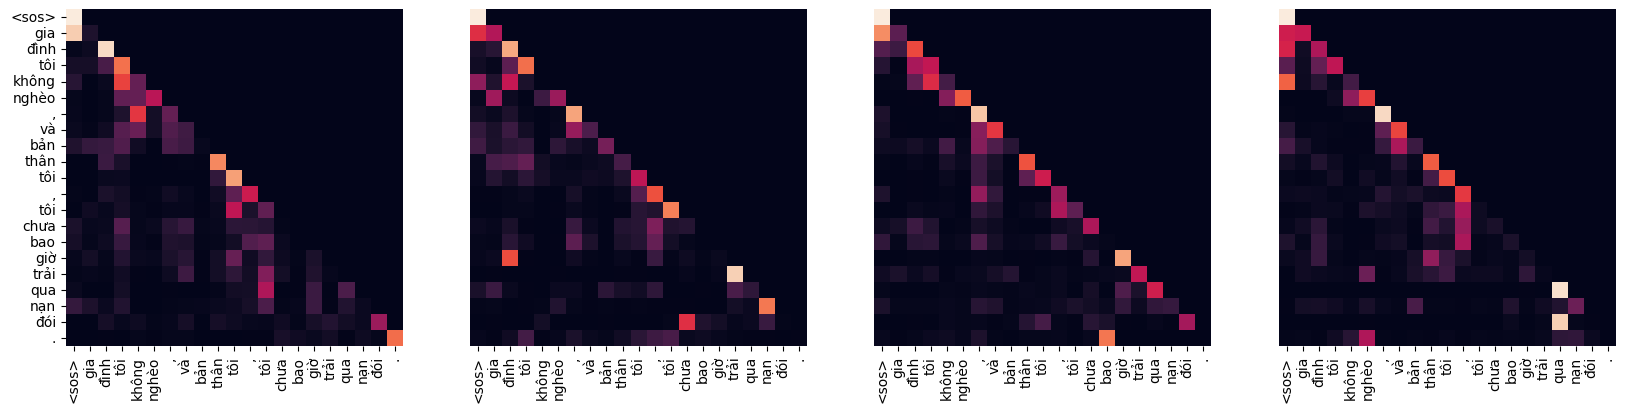

Decoder Src Layer 6


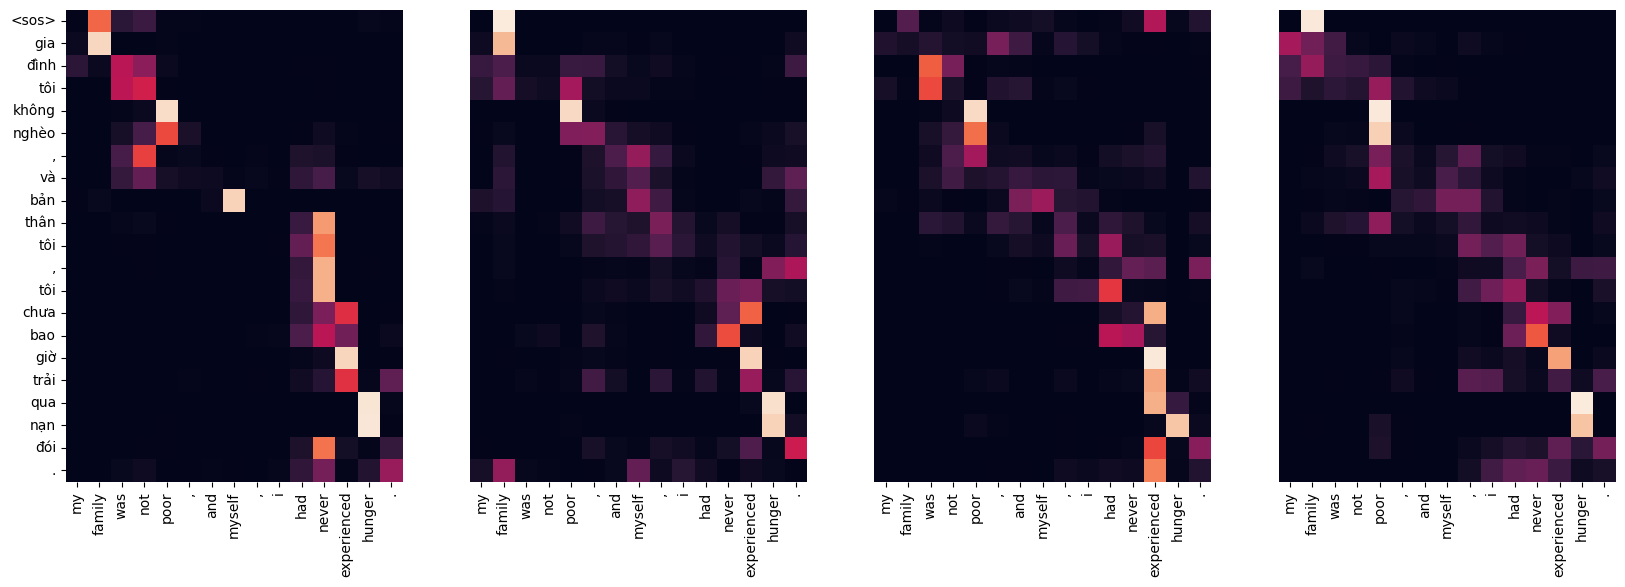

In [48]:
trg_sent = ['<sos>'] + TRG.preprocess(trans_sent)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].attn_1.attn[0, h].data[:len(trg_sent), :len(trg_sent)].cpu(),
            trg_sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].attn_2.attn[0, h].data[:len(trg_sent), :len(sent)].cpu(),
            sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()